In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, utils, backend, callbacks

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

!pip install uproot
import uproot

from google.colab import drive

2024-01-23 15:06:26.661122: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-23 15:06:26.812618: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-23 15:06:27.826144: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


ModuleNotFoundError: No module named 'google.colab'

In [2]:
#@keras.saving.register_keras_serializable(package="CustomModel", name="DNN2")
class DNN(keras.Model):
    def __init__(self, sizes=(100, 100, 100), outputDims=2, inputDims=None, **kwargs):
        super().__init__(**kwargs)
        self._outputShape=outputDims
        self._denseSizes=sizes
        self._inputShape=inputShape

        self._inputs = keras.Input(shape=inputDims)
        self._layers = []
        for i, size in enumerate(sizes):
            _layer = layers.Dense(size, kernel_initializer="he_uniform", kernel_regularizer=keras.regularizers.L1L2(l2=1e-4))
            _activation = layers.Activation("relu")
            self._layers.extend([_layer, _activation])

        _layer = layers.Dense(outputDims)
        _activation = layers.Activation("softmax")
        self._layers.extend([_layer, _activation])

        self._outputs = self.call(self._inputs)
        self._model = keras.Model(self._inputs, self._outputs)

    def call(self, inputs):
        self._tensors = [inputs]
        for _layer in self._layers:
            tensor = _layer(self._tensors[-1])
            self._tensors.append(tensor)
        return self._tensors[-1]

    def get_config(self):
        config = super().get_config()
        config.update({
            "sizes": self._denseSizes,
            "outputDims": self._outputShape,
            "inputDims": self._inputShape,
        })
        return config

    def model(self):
        return self._model

In [3]:
scaler = StandardScaler()

In [ ]:
drive.mount("/content/gdrive", force_remount=True)

matches = uproot.open("/content/gdrive/My Drive/dataFiles/embeddingNtuples_20231023_4256.root:matches")
#matches.show()

columns = ["_wt", "_pt", "_eta", "_phi", "_nCharged", "_girth", "_ptd", "_lesub"]

reco = matches["recoJet"]
recoJets = reco.arrays(columns , library="pd")

gen = matches["genJet"]
genJets = gen.arrays(columns, library="pd")

print(recoJets.head())
print(genJets.head())

trainGen, testGen, trainReco, testReco = train_test_split(genJets, recoJets, test_size=0.2)

print("train-test split Gen: ", trainGen.shape, testGen.shape)
print(trainGen.head())
print(testGen.head())

print("train-test split Reco: ", trainReco.shape, testReco.shape)
print(trainReco.head())
print(testReco.head())


trainWts = trainGen["_wt"]
trainWts = trainWts/trainWts.mean()
print("Sum of training weights: ", trainWts.sum())

testWts = testGen["_wt"]
testWts = testWts/testWts.mean()

testGen["_wt"] = testWts
testReco["_wt"] = testWts

print("Sum of testing weights: ", testWts.sum())

scaler = StandardScaler()

features = ["_pt", "_eta", "_phi", "_nCharged", "_girth", "_ptd", "_lesub"]

X_det = scaler.fit_transform((pd.concat([testReco[features], trainReco[features]], ignore_index=True, sort=False)))
X_gen = scaler.fit_transform((pd.concat([trainGen[features], trainGen[features]], ignore_index=True, sort=False)))

Y_det = utils.to_categorical(np.concatenate((np.ones(testReco.shape[0]), np.zeros(trainReco.shape[0]))))
Y_gen = utils.to_categorical(np.concatenate((np.ones(trainGen.shape[0]), np.zeros(trainGen.shape[0]))))

print("detector-level input shapes: ", X_det.shape, Y_det.shape)
print("generator-level input shapes: ", X_gen.shape, Y_gen.shape)


Mounted at /content/gdrive
            _wt        _pt      _eta      _phi  _nCharged    _girth      _ptd  \
0  2.664058e-09  14.526236  0.160680  5.232878          3  0.089224  0.354457   
1  2.664058e-09  14.171301  0.034624  3.213783          2  0.039629  0.615257   
2  2.664058e-09  10.375666  0.582861  3.944160          2  0.088296  0.528615   
3  2.664058e-09  12.337531 -0.537796  4.923559          3  0.106382  0.370036   
4  2.664058e-09  10.943662 -0.097477  4.372401          2  0.030195  0.501469   

     _lesub  
0  1.940472  
1  4.263633  
2  1.316851  
3  0.610686  
4  0.593166  
            _wt        _pt      _eta      _phi  _nCharged    _girth      _ptd  \
0  2.664058e-09  14.522670  0.156882  5.231541          3  0.087030  0.359391   
1  2.664058e-09  14.867034  0.034164  3.198580          2  0.045064  0.611604   
2  2.664058e-09  11.343337  0.597785  3.944903          2  0.082767  0.523744   
3  2.664058e-09  12.382342 -0.535900  4.923663          3  0.106021  0.370155 

In [ ]:
nData, nEmbedding = np.count_nonzero(Y_det[:,1]), np.count_nonzero(Y_det[:,0])
#wtest[key] = np.ones(ntest[key])
wData = testWts.to_numpy()
#wtrain[key] = ntest[key]/ntrain[key]*np.ones(ntrain[key])
wEmbedding = (testWts.sum()/trainWts.sum()*trainWts).to_numpy()

print(np.sum(wEmbedding), np.sum(wData))
print(np.sum(testWts), np.sum(trainWts))

#now = datetime.now()
#nownow = now.strftime("%d-%m-%Y_%H-%M-%S")
folderPath = "/content/gdrive/MyDrive/savedModels/savedModel_"

lossFunc="binary_crossentropy"
optimizer="adam"
metricList=["accuracy"]

patience=10

validationSize = 0.2
nEpochs = 50
batchSize = 1000

inputShape = X_det.shape[1:]

w_sim = [wEmbedding]
nIter = 4
for i in range(nIter):
  detModel = DNN(sizes=(100, 100, 100), outputDims=2, inputDims=inputShape)
  detModel.compile(loss=lossFunc, optimizer=optimizer, metrics=metricList, weighted_metrics=[])
  detModel.model().summary()
  detCallBacks = [callbacks.EarlyStopping(patience=patience, verbose=1, restore_best_weights=True)]
  detModelFilePath = folderPath + f"step1_iteration{i}"+"_epoch{epoch}"
  detCallBacks.append(callbacks.ModelCheckpoint(detModelFilePath, save_best_only=True, verbose=1))

  genModel = DNN(sizes=(100, 100, 100), outputDims=2, inputDims=inputShape)
  genModel.compile(loss=lossFunc, optimizer=optimizer, metrics=metricList, weighted_metrics=[])
  genModel.model().summary()
  genCallBacks = [callbacks.EarlyStopping(patience=patience, verbose=1, restore_best_weights=True)]
  genModelFilePath = folderPath + f"step2_iteration{i}"+"_epoch{epoch}"
  genCallBacks.append(callbacks.ModelCheckpoint(genModelFilePath, save_best_only=True, verbose=1))

  if(i > 0):
    detModel.load_weights(folderPath + f"step1_iteration{i-1}")
    genModel.load_weights(folderPath + f"step2_iteration{i-1}")

  w_det = np.concatenate([wData, w_sim[-1]])

  X_det_train, X_det_val, Y_det_train, Y_det_val, w_det_train, w_det_val = train_test_split(X_det, Y_det, w_det, test_size=validationSize)
  detModel.fit(X_det_train, Y_det_train, sample_weight=w_det_train, epochs=nEpochs, batch_size=batchSize, validation_data=(X_det_val, Y_det_val, w_det_val), verbose=1, callbacks=detCallBacks)
  detModel.save_weights(folderPath + f"step1_iteration{i}")
  prediction = detModel.predict(X_det, batch_size=batchSize*10)
  scaleFactors = prediction[Y_det[:, 0] == 1]

  _pull = (scaleFactors[:, 1]/(scaleFactors[:, 0] + backend.epsilon()))*w_sim[-1]
  w_sim.append(_pull)

  w_gen = np.concatenate([w_sim[-1], w_sim[0]])

  X_gen_train, X_gen_val, Y_gen_train, Y_gen_val, w_gen_train, w_gen_val = train_test_split(X_gen, Y_gen, w_gen, test_size=validationSize)
  genModel.fit(X_gen_train, Y_gen_train, sample_weight=w_gen_train, epochs=nEpochs, batch_size=batchSize, validation_data=(X_gen_val, Y_gen_val, w_gen_val), verbose=1, callbacks=genCallBacks)
  genModel.save_weights(folderPath + f"step2_iteration{i}")
  prediction = genModel.predict(X_gen, batch_size=batchSize*10)
  scaleFactors = prediction[Y_gen[:, 0] == 1]

  _push = (scaleFactors[:, 1]/(scaleFactors[:, 0] + backend.epsilon()))*w_sim[-1]
  w_sim.append(_push)


435430.99999999977 435430.99999999994
435430.99999999994 1741722.9999999998
Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 7)]               0         
                                                                 
 dense_72 (Dense)            (None, 100)               800       
                                                                 
 activation_72 (Activation)  (None, 100)               0         
                                                                 
 dense_73 (Dense)            (None, 100)               10100     
                                                                 
 activation_73 (Activation)  (None, 100)               0         
                                                                 
 dense_74 (Dense)            (None, 100)               10100     
                                                

In [ ]:
#columns = ["_wt", "_pt", "_eta", "_phi", "_nCharged", "_girth", "_ptd", "_lesub"]
feature = "_nCharged"
Min = 0.
Max = 13.
nBins = 12

cpt1, binpt1 = np.histogram(trainGen[feature], bins=nBins, range=(Min, Max), weights=w_sim[-1], density=True)
cpt2, binpt2 = np.histogram(testGen[feature], bins=nBins, range=(Min, Max), weights=testWts, density=True)
cpt3, binpt3 = np.histogram(testReco[feature], bins=nBins, range=(Min, Max), weights=testWts, density=True)

#crat = cpt1/cpt2
#crat1 = cpt3/cpt2

#plt.hist(binpt1[:-1], binpt1, weights=crat1)
#plt.hist(binpt1[:-1], binpt1, weights=crat)

#plt.yscale("log")

(array([0.00000000e+00, 6.17528063e-01, 2.44123219e-01, 5.22937632e-02,
        7.85359577e-03, 1.19437022e-03, 7.55672558e-05, 6.38509225e-06,
        1.89323365e-06, 6.09715189e-08, 5.89956328e-09, 1.83898896e-10]),
 array([ 0.        ,  1.08333333,  2.16666667,  3.25      ,  4.33333333,
         5.41666667,  6.5       ,  7.58333333,  8.66666667,  9.75      ,
        10.83333333, 11.91666667, 13.        ]),
 <BarContainer object of 12 artists>)

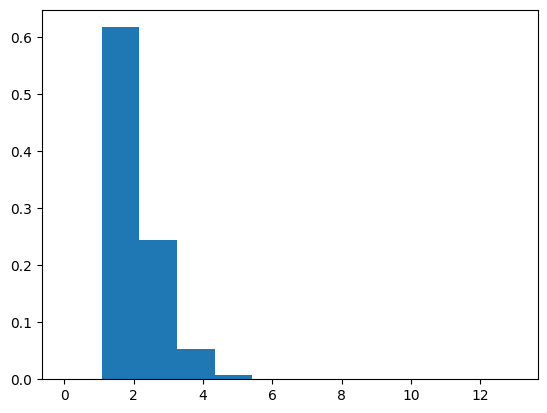

In [ ]:
plt.hist(binpt1[:-1], binpt1, weights=cpt3)